In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchviz import make_dot

In [33]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])
                                        
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                          shuffle=True, num_workers=4)

valloader = torch.utils.data.DataLoader(val_dataset, batch_size=64,
                                        shuffle=False, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
                                       
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=4)



Using device: cuda
Files already downloaded and verified
Files already downloaded and verified


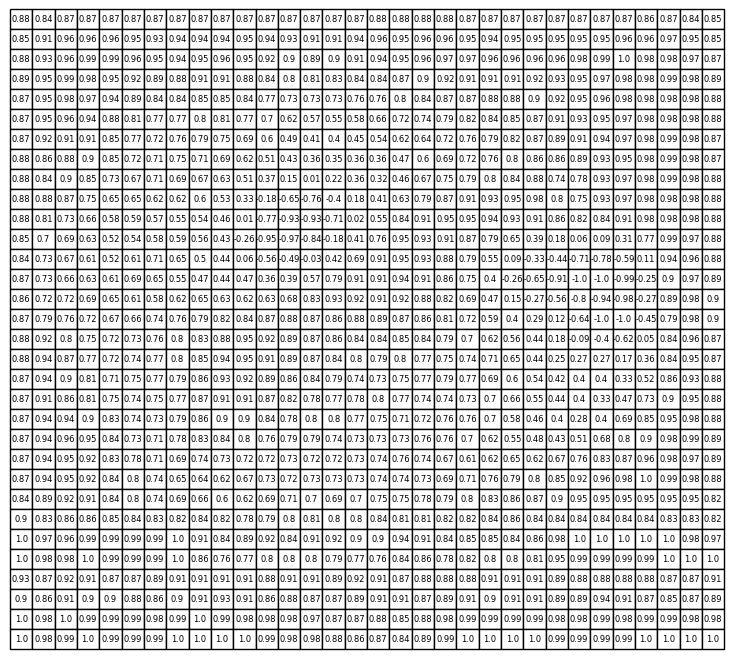

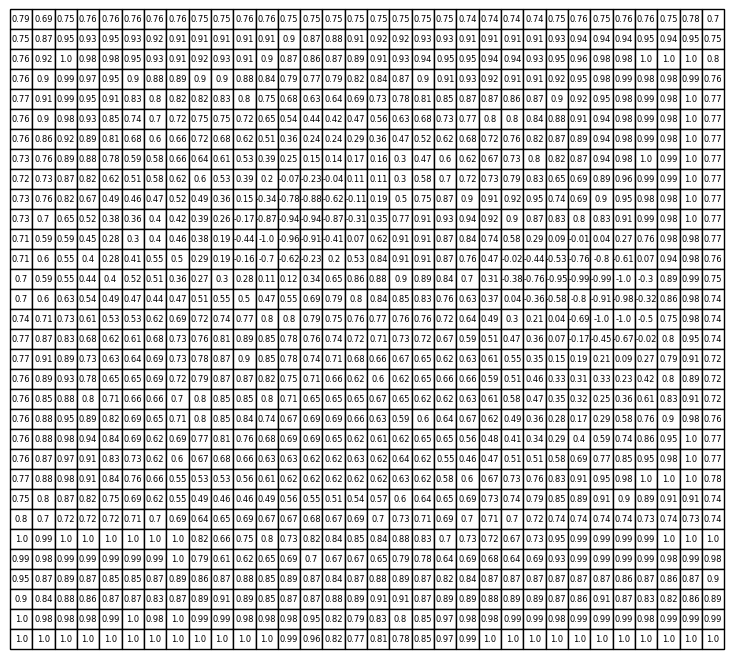

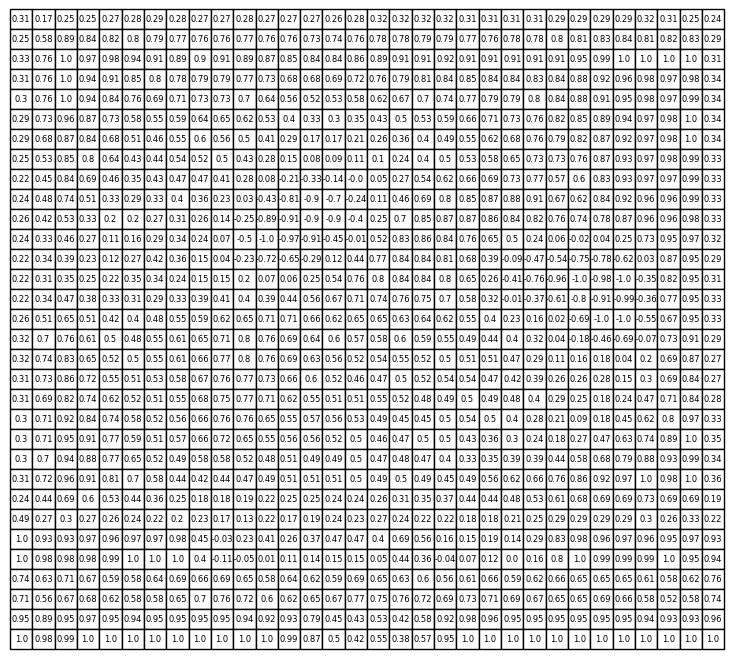

In [15]:

import matplotlib.pyplot as plt
import numpy as np
import torchvision

def show_channel_as_table(tensor_img, channel=0):
    """
    Show one channel of the image tensor as a table.
    """
    # Unnormalize the image
    #tensor_img = tensor_img * 0.5 + 0.5  # Convert from [-1, 1] to [0, 1]

    # Extract the specific channel and convert to numpy
    channel_data = tensor_img[channel].numpy()
    channel_data = np.round(channel_data, 2)  # Round for readability

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.axis('tight')
    ax.axis('off')

    # Create table
    table = ax.table(cellText=channel_data,
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.03]*channel_data.shape[1])

    # Style table
    table.scale(1.2, 1.2)
    table.auto_set_font_size(False)
    table.set_fontsize(6)

    #plt.title(f'Channel {channel} as Table ({"RGB"[channel]})')
    plt.show()

# Get a batch of data
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show the first image's first channel as a table
show_channel_as_table(images[0], channel=0)  # 0=Red, 1=Green, 2=Blue
show_channel_as_table(images[0], channel=1)  # 0=Red, 1=Green, 2=Blue
show_channel_as_table(images[0], channel=2)  # 0=Red, 1=Green, 2=Blue

In [37]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #convolutional layers
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) 
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        #pooling
        self.pool = nn.MaxPool2d(2,2)
        
        #fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):

        #conv -> activation (relu) -> pool x3
        out = self.pool(F.relu(self.conv1(x)))
        out = self.pool(F.relu(self.conv2(out)))
        out = self.pool(F.relu(self.conv3(out)))
        
        #flatten
        #Conv = (input_size - kernel_size + 2 * padding)/stride + 1 = (32 - 3 + 2 * 1)/1 + 1 = 32
        #Kernel = (input_size(after pooling) - pool_size)/stride + 1 = (16 - 2)/2 + 1 = 8 (stride is 2 because of pooling)
        out = out.view(-1, 64 * 4 * 4) 
        
        #fully-connected layer
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        
        return out

net = Net().to(device)
net

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [39]:
epochs = 50
for epoch in range(epochs):  

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        net.train()
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    avg_running_loss = running_loss / len(trainloader)
    print(f'Epoch [{epoch+1}/{epochs}] Training loss: {avg_running_loss:.4f}')

    net.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
                
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Validation loss: {val_loss/len((valloader)):.4f}, Accuracy: {100*correct/total:.2f}%')
        

print('Finished Training')



Epoch [1/50] Training loss: 2.2664
Validation loss: 2.1810, Accuracy: 22.78%
Epoch [2/50] Training loss: 2.0517
Validation loss: 1.9574, Accuracy: 29.11%
Epoch [3/50] Training loss: 1.8891
Validation loss: 1.8239, Accuracy: 34.44%
Epoch [4/50] Training loss: 1.7436
Validation loss: 1.6701, Accuracy: 39.77%
Epoch [5/50] Training loss: 1.6027
Validation loss: 1.5607, Accuracy: 42.63%
Epoch [6/50] Training loss: 1.5027
Validation loss: 1.4662, Accuracy: 47.48%
Epoch [7/50] Training loss: 1.4391
Validation loss: 1.4458, Accuracy: 48.25%
Epoch [8/50] Training loss: 1.3829
Validation loss: 1.3616, Accuracy: 51.17%
Epoch [9/50] Training loss: 1.3309
Validation loss: 1.3219, Accuracy: 52.68%
Epoch [10/50] Training loss: 1.2914
Validation loss: 1.3003, Accuracy: 53.31%
Epoch [11/50] Training loss: 1.2454
Validation loss: 1.2541, Accuracy: 55.47%
Epoch [12/50] Training loss: 1.2075
Validation loss: 1.2198, Accuracy: 56.46%
Epoch [13/50] Training loss: 1.1700
Validation loss: 1.1991, Accuracy: 57


 Accuracy: 68.96%


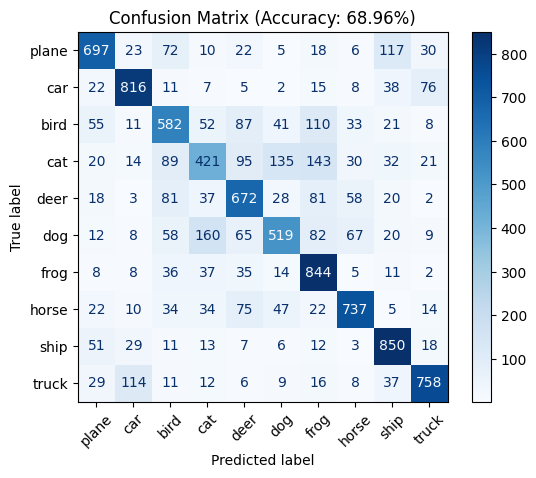


 F1 Score (Macro):    0.6852
 F1 Score (Micro):    0.6896
 F1 Score (Weighted): 0.6852


In [40]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, f1_score
)
import matplotlib.pyplot as plt
import torch
import numpy as np

# CIFAR-10 class labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Make sure model is in evaluation mode and on the correct device
net.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

# Track predictions and labels
all_preds = []
all_probs = []
all_labels = []

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        probs = torch.softmax(outputs, dim=1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Accuracy
accuracy = 100 * correct / total
print(f"\n Accuracy: {accuracy:.2f}%")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title(f'Confusion Matrix (Accuracy: {accuracy:.2f}%)')
#plt.tight_layout()
plt.show()

# F1 Scores
f1_macro = f1_score(all_labels, all_preds, average='macro')
f1_micro = f1_score(all_labels, all_preds, average='micro')
f1_weighted = f1_score(all_labels, all_preds, average='weighted')

print(f"\n F1 Score (Macro):    {f1_macro:.4f}")
print(f" F1 Score (Micro):    {f1_micro:.4f}")
print(f" F1 Score (Weighted): {f1_weighted:.4f}")
